In [ ]:
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

#Definición para el calculo de metricas multi-clase
def calculo_metricas(CM, emociones):
    
    emocion = []
    TruPos = []
    FalPos = []
    FalNeg = []
    TruNeg = []
    acc = []
    prec = []
    recall = []
    f1 = []
    
    total = np.sum(CM)
    
    for i in range(len(emociones)):
       
        TP = CM[i][i]
        FP = sum(CM[:,i])-TP
        FN = sum(CM[i,:])-TP
        TN = total - TP-FN-FP
        a = (TP+TN)/(TP+TN+FN+FP)
        p = TP/(TP+FP)
        r = TP/(TP+FN)
        f = 2*(r*p)/(r+p)
        
        emocion.append(emociones[i])
        TruPos.append(TP)
        FalPos.append(FP)
        TruNeg.append(TN)
        acc.append(a)
        prec.append(p)
        recall.append(r)
        f1.append(f)
    
    metricas = pd.DataFrame()
    metricas['Emociones']=emocion
    metricas['Accuracy']=acc
    metricas['Precision']=prec
    metricas['Recall']=recall
    metricas['F1-Score']=f1
    
    return metricas

def graf_confusion_matrix(CM, emociones,emb):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(CM,annot=True,fmt='',xticklabels=emociones,yticklabels=emociones, ax=ax, cmap='Blues');
    ax.set_title('Matriz de confusión '+emb);
    ax.set_xlabel('Valores Predecidos');
    ax.set_ylabel('Valores Verdaderos');
    
def graficar_historia_entrenamiento(log, metric='accuracy'):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(log.history['val_loss'], label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history[metric], label='train')
    ax2.plot(log.history['val_'+metric], label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel(metric)
    #ax2.set_ylim((0.0, 1.0))
    for ax in axes: ax.legend()

In [ ]:
# ================================== Cargamos la data desde drive
from google.colab import drive

drive.mount('/content/drive')

# En esta parte se estan cargando los directorios correspondientes a las 
# imagenes del affectnet tanto el conjunto de entrenamiento como el de 
# validación
train_path = '/content/drive/My Drive/Proyecto_DL/dataset_kdef/train'
valid_path = '/content/drive/My Drive/Proyecto_DL/dataset_kdef/test'
train_image_files = glob(train_path +'/*/*.jpg')
valid_image_files = glob(valid_path +'/*/*.jpg')


Mounted at /content/drive


In [ ]:
# Se imprimen para verificar los directorios, existen 6 clases
folders = glob(train_path + '/*')
print(folders)

['/content/drive/My Drive/Proyecto_DL/dataset_kdef/train/0', '/content/drive/My Drive/Proyecto_DL/dataset_kdef/train/1', '/content/drive/My Drive/Proyecto_DL/dataset_kdef/train/2', '/content/drive/My Drive/Proyecto_DL/dataset_kdef/train/3', '/content/drive/My Drive/Proyecto_DL/dataset_kdef/train/4', '/content/drive/My Drive/Proyecto_DL/dataset_kdef/train/5']


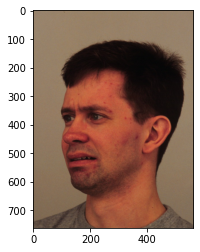

In [ ]:
# Presentamos un ejemplo
plt.imshow(image.load_img(np.random.choice(valid_image_files)))
plt.show()

In [ ]:
IMAGE_SIZE = [64,64]
#Se crea un Image Generator para incluir el pre-procesamiento de imagenes correspondiente a la arquitectura ResNet
gen = ImageDataGenerator()

In [ ]:
#Se crean los generadores deimagenes a partir  de los directorios
# con un batch-size de 128
batch_size = 128

#Generador para el conjunto de entrenamiento
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)
# Generador para el conjunto de validación
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)

Found 3358 images belonging to 6 classes.
Found 840 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [ ]:
#Modeo mi-Xception extraido de (https://github.com/oarriaga/face_classification/tree/master/src/models)
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model

In [ ]:
#Instancia del modelo 1: mini_XCEPTION
miniXception = mini_XCEPTION(input_shape=(64,64,3), num_classes=6)
#miniXception.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
#Callabacks
patience = 10
early_stop = EarlyStopping('val_loss',patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss',factor=0.1, patience=int(patience/4), verbose=1)
callbacks = [early_stop, reduce_lr]

miniXception.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy', 
                     metrics=[tf.keras.metrics.sparse_categorical_accuracy])

log_r = miniXception.fit(train_generator,
                         batch_size=128,
                         epochs=20, 
                         verbose=1, 
                         callbacks=callbacks,
                         validation_data=valid_generator)

Epoch 1/20
27/27 [==============================] - 1143s 42s/step - loss: 1.9951 - sparse_categorical_accuracy: 0.2162 - val_loss: 2.2025 - val_sparse_categorical_accuracy: 0.1667
Epoch 2/20
27/27 [==============================] - 76s 3s/step - loss: 1.7061 - sparse_categorical_accuracy: 0.3562 - val_loss: 2.1024 - val_sparse_categorical_accuracy: 0.1702
Epoch 3/20
27/27 [==============================] - 75s 3s/step - loss: 1.4308 - sparse_categorical_accuracy: 0.4869 - val_loss: 2.0453 - val_sparse_categorical_accuracy: 0.1679
Epoch 4/20
27/27 [==============================] - 76s 3s/step - loss: 1.1884 - sparse_categorical_accuracy: 0.5864 - val_loss: 1.9277 - val_sparse_categorical_accuracy: 0.1774
Epoch 5/20
27/27 [==============================] - 76s 3s/step - loss: 0.9975 - sparse_categorical_accuracy: 0.6605 - val_loss: 1.9049 - val_sparse_categorical_accuracy: 0.2036
Epoch 6/20
27/27 [==============================] - 76s 3s/step - loss: 0.8705 - sparse_categorical_accurac

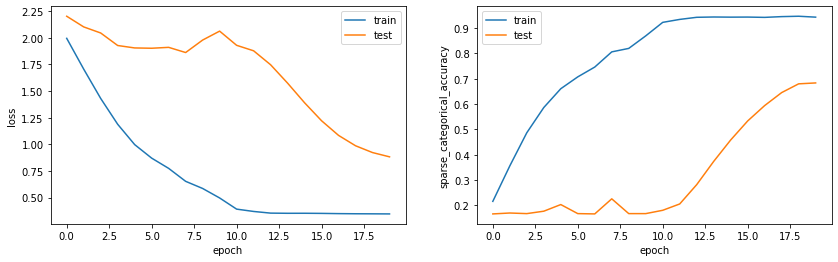

In [ ]:
graficar_historia_entrenamiento(log_r, metric='sparse_categorical_accuracy')

In [ ]:
N_valid = len(valid_image_files)
Y_valid = np.zeros(N_valid)
Y_pred = np.zeros(N_valid)

i = 0
for x, y in valid_generator:
    pred = miniXception.predict(x)
  
    sz = len(y) 
    Y_pred[i:i+sz]= np.argmax(pred,axis=1)
    Y_valid[i:i+sz]=y

    i += sz
    if i%1280==0:
        print(i)

    if i>=N_valid:
        print('breaking now')
        break

print(i)

breaking now
840


In [ ]:
ind = 235
print(Y_valid[ind], Y_pred[ind])

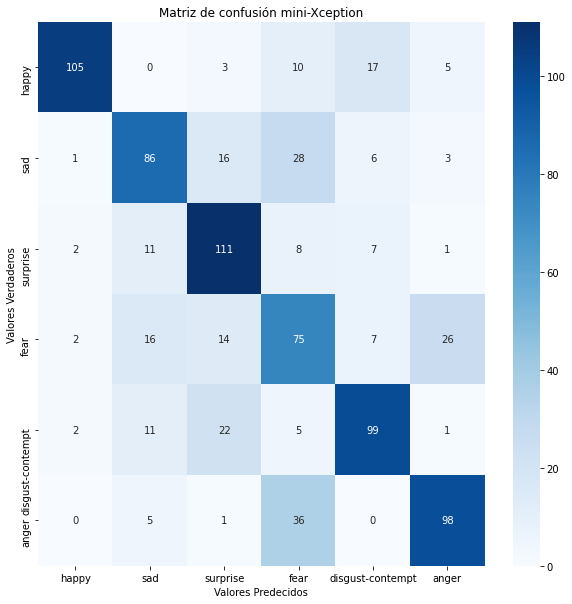

In [ ]:
emo_dict = {0: 'happy', 1: 'sad', 2: 'surprise', 3: 'fear', 4: 'disgust-contempt', 5: 'anger'}
emociones_1 = list(emo_dict.values())

CM_mini = confusion_matrix(Y_valid, Y_pred)
graf_confusion_matrix(CM_mini, emociones_1 ,'mini-Xception')

In [ ]:
m1 = calculo_metricas(CM_mini, emociones_1)
m1

,Emociones,Accuracy,Precision,Recall,F1-Score
0,happy,0.950000,0.937500,0.750000,0.833333
1,sad,0.884524,0.666667,0.614286,0.639405
2,surprise,0.898810,0.664671,0.792857,0.723127
3,fear,0.819048,0.462963,0.535714,0.496689
4,disgust-contempt,0.907143,0.727941,0.707143,0.717391
5,anger,0.907143,0.731343,0.700000,0.715328


In [ ]:
m1.mean()

Accuracy     0.894444
Precision    0.698514
Recall       0.683333
F1-Score     0.687546
dtype: float64

In [ ]:
# Guardamos el modelo Final
miniXception.save('miniXception_emotions_v1_5epochs.h5')